# Module 6

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import truncnorm
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import random
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
import re
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def truncated_normal(mean, std, lower, upper, size):
    a, b = (lower - mean) / std, (upper - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std, size=size)

ranges = {
    "mu": (1e9, 70e9),
    "rho": (2000, 3500),
    "lambda": (1e9, 50e9)
}

mu_mean = (ranges["mu"][0] + ranges["mu"][1]) / 2
mu_std = (ranges["mu"][1] - ranges["mu"][0]) / 4  

rho_mean = (ranges["rho"][0] + ranges["rho"][1]) / 2
rho_std = (ranges["rho"][1] - ranges["rho"][0]) / 4  

lambda_mean = (ranges["lambda"][0] + ranges["lambda"][1]) / 2
lambda_std = (ranges["lambda"][1] - ranges["lambda"][0]) / 4  

def sample_parameters(n_samples):
    np.random.seed(42)
    sampled_data = {"mu (Pa)": [], "rho (kg/m^3)": [], "lambda (Pa)": [], "p_v (m/s)": [], "s_v (m/s)": []}

    mu = truncated_normal(mu_mean, mu_std, lower=ranges["mu"][0], upper=ranges["mu"][1], size=n_samples)
    rho = truncated_normal(rho_mean, rho_std, lower=ranges["rho"][0], upper=ranges["rho"][1], size=n_samples)
    lambda_ = truncated_normal(lambda_mean, lambda_std, lower=ranges["lambda"][0], upper=ranges["lambda"][1], size=n_samples)
        
    for i in range(n_samples):
        p_v = np.sqrt((lambda_[i] + 2 * mu[i]) / rho[i])
        s_v = np.sqrt(mu[i] / rho[i])
        
        sampled_data["mu (Pa)"].append(mu[i])
        sampled_data["rho (kg/m^3)"].append(rho[i])
        sampled_data["lambda (Pa)"].append(lambda_[i])
        sampled_data["p_v (m/s)"].append(p_v)
        sampled_data["s_v (m/s)"].append(s_v)

    return pd.DataFrame(sampled_data)

n_samples = 100
os.makedirs("SyntheticData", exist_ok=True)
data = sample_parameters(n_samples)
data.to_csv("SyntheticData/seismic_data.csv", index=False)
print(data.head())

        mu (Pa)  rho (kg/m^3)   lambda (Pa)    p_v (m/s)    s_v (m/s)
0  3.024172e+10   2142.964392  2.974634e+10  6488.845927  3756.606839
1  6.098398e+10   2874.647339  1.001236e+10  6775.826874  4605.911548
2  4.562781e+10   2577.546729  1.414715e+10  6394.737415  4207.377850
3  3.961040e+10   2757.690300  3.991933e+10  6572.888637  3789.935696
4  1.915412e+10   3208.003984  2.865383e+10  4568.746131  2443.507678


In [3]:
def bandpass_filter(data, lowcut=0.1, highcut=15.0, fs=100, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def generate_realistic_waveform(duration=600, sampling_rate=100, p_v=4000, s_v=2500):
    t = np.linspace(0, duration, int(duration * sampling_rate))
    p_start_fraction = random.uniform(0.05, 0.2)
    p_arrival = int((duration * p_start_fraction) * sampling_rate)
    s_arrival = p_arrival + int((p_arrival/sampling_rate) * (p_v/s_v) * sampling_rate)
    
    background = np.zeros(len(t))
    for freq in [0.5, 1, 2, 3, 4]:
        background += np.random.normal(0, 20) * np.sin(2 * np.pi * freq * t)
    
    signal = np.zeros(len(t))
    
    for i in range(p_arrival, s_arrival):
        t_local = (i - p_arrival) / sampling_rate
        for freq in [3, 4, 5, 6, 7]:
            phase = np.random.uniform(0, 2*np.pi)
            amplitude = np.random.uniform(300, 600) * np.exp(-t_local/(p_v/1000))
            signal[i] += amplitude * np.sin(2*np.pi*freq*t_local + phase)
    
    for i in range(s_arrival, len(t)):
        t_local = (i - s_arrival) / sampling_rate
        for freq in [1, 2, 3, 4]:
            phase = np.random.uniform(0, 2*np.pi)
            amplitude = np.random.uniform(500, 1000) * np.exp(-t_local/(s_v/1000))
            signal[i] += amplitude * np.sin(2*np.pi*freq*t_local + phase)
    
    signal += np.random.normal(0, 200, len(t))    
    waveform = signal + background
    waveform = bandpass_filter(waveform)
    
    return t, waveform

os.makedirs("SimulatedWaveforms", exist_ok=True)

for i in range(n_samples):
    p_v = data.loc[i, "p_v (m/s)"]
    s_v = data.loc[i, "s_v (m/s)"]
    
    t, waveform = generate_realistic_waveform(duration=600, sampling_rate=20, p_v=p_v, s_v=s_v)
    
    df = pd.DataFrame({"Relative Time (s)": t, "Velocity (Amplitude)": waveform})
    
    filename = f"SimulatedWaveforms/{i}_seismic_waveform.csv"
    df.to_csv(filename, index=False)


In [4]:
import os
import pandas as pd
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import re

def calculate_waveform_features(df):
    t = df['Relative Time (s)'].values
    waveform = df['Velocity (Amplitude)'].values
    max_amplitude = np.max(np.abs(waveform))
    
    N = len(waveform)
    T = t[1] - t[0]
    
    yf = fft(waveform)
    xf = fftfreq(N, T)[:N//2]
    
    peak_indices = find_peaks(np.abs(yf[:N//2]))[0]
    if len(peak_indices) > 0:
        dominant_frequency = xf[peak_indices[np.argmax(np.abs(yf[peak_indices]))]]
        phase_shift = np.angle(yf[peak_indices[np.argmax(np.abs(yf[peak_indices]))]])
    else:
        dominant_frequency = 0
        phase_shift = 0
    
    return max_amplitude, dominant_frequency, phase_shift


seismic_data = pd.read_csv("SyntheticData/seismic_data.csv")


file_paths = [os.path.join("SimulatedWaveforms", f) for f in os.listdir("SimulatedWaveforms") if f.endswith(".csv") and "features" not in f]

features = []

for file_path in file_paths:
    df = pd.read_csv(file_path)
    max_amplitude, dominant_frequency, phase_shift = calculate_waveform_features(df)
    
    
    filename = os.path.basename(file_path)
    match = re.search(r"(\d+)_seismic_waveform.csv", filename)
    if match:
        
        idx = int(match.group(1))
        p_v = seismic_data.loc[idx, "p_v (m/s)"]
        s_v = seismic_data.loc[idx, "s_v (m/s)"]
        
        features.append({
            "p_v (m/s)": p_v, 
            "s_v (m/s)": s_v, 
            "Max Amplitude": max_amplitude, 
            "Dominant Frequency (Hz)": dominant_frequency, 
            "Phase Shift (radians)": phase_shift
        })


features_df = pd.DataFrame(features)


seismic_data = seismic_data.merge(features_df, on=["p_v (m/s)", "s_v (m/s)"], how="left")


seismic_data.to_csv("SyntheticData/seismic_data.csv", index=False)

print("Amplitude, frequency, and phase shift have been calculated and saved.")


Amplitude, frequency, and phase shift have been calculated and saved.


Summary table created and saved as 'waveform_summary.csv'.


<Figure size 1200x500 with 0 Axes>

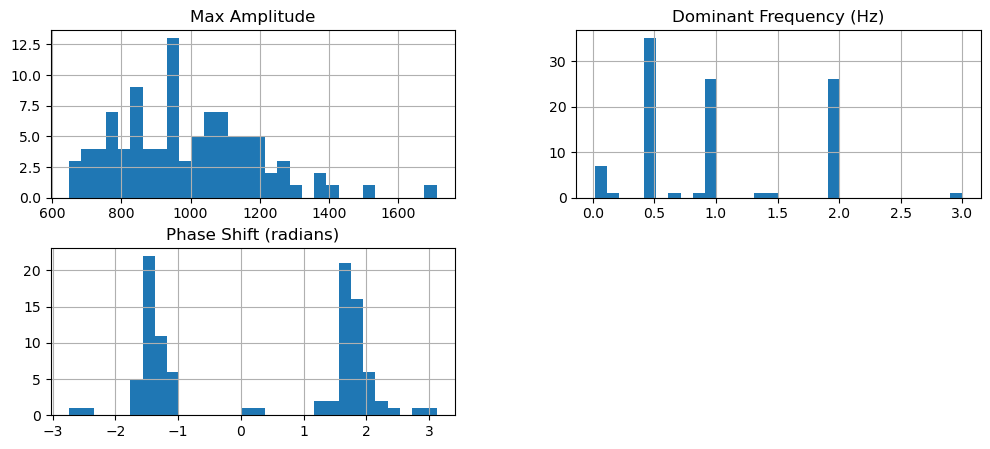

In [5]:

summary_df = pd.DataFrame(seismic_data)


summary_df.to_csv("waveform_summary.csv", index=False)

print("Summary table created and saved as 'waveform_summary.csv'.")


summary_df.head(10).style.set_properties(**{
    "background-color": "aqua", 
    "color": "#000000", 
    "border": "1.5px solid #5f0d11"
})


summary_df.describe()


data = summary_df.copy()


plt.figure(figsize=(12, 5))
data[['Max Amplitude', 'Dominant Frequency (Hz)', 'Phase Shift (radians)']].hist(bins=30, figsize=(12, 5))
plt.show()


In [6]:
amplitude_threshold = 900
frequency_lower_threshold = 0.5
frequency_upper_threshold = 1.5
phase_shift_threshold = 1.5


def classify_zone(row):
    if (row['Max Amplitude'] < amplitude_threshold) or \
       (row['Dominant Frequency (Hz)'] < frequency_lower_threshold) or \
       (row['Dominant Frequency (Hz)'] > frequency_upper_threshold) or \
       (abs(row['Phase Shift (radians)']) > phase_shift_threshold):
        return "Shadow Zone"
    else:
        return "Non-Shadow Zone"


data['Zone'] = data.apply(classify_zone, axis=1)


data.to_csv("classified_seismic_data.csv", index=False)

print(data)

         mu (Pa)  rho (kg/m^3)   lambda (Pa)    p_v (m/s)    s_v (m/s)  \
0   3.024172e+10   2142.964392  2.974634e+10  6488.845927  3756.606839   
1   6.098398e+10   2874.647339  1.001236e+10  6775.826874  4605.911548   
2   4.562781e+10   2577.546729  1.414715e+10  6394.737415  4207.377850   
3   3.961040e+10   2757.690300  3.991933e+10  6572.888637  3789.935696   
4   1.915412e+10   3208.003984  2.865383e+10  4568.746131  2443.507678   
..           ...           ...           ...          ...          ...   
95  3.524392e+10   2611.631758  2.615224e+10  6083.068065  3673.551650   
96  3.643869e+10   2963.764912  3.406215e+10  6006.856693  3506.384254   
97  3.249434e+10   3188.828513  1.639867e+10  5051.994430  3192.186551   
98  6.614259e+09   3171.465356  2.915533e+10  3655.697194  1444.144385   
99  1.571773e+10   3023.549092  1.009075e+10  3705.975834  2280.007949   

    Max Amplitude  Dominant Frequency (Hz)  Phase Shift (radians)         Zone  
0      818.000839             

        mu (Pa)  rho (kg/m^3)   lambda (Pa)    p_v (m/s)    s_v (m/s)  \
0  3.024172e+10   2142.964392  2.974634e+10  6488.845927  3756.606839   
1  6.098398e+10   2874.647339  1.001236e+10  6775.826874  4605.911548   
2  4.562781e+10   2577.546729  1.414715e+10  6394.737415  4207.377850   
3  3.961040e+10   2757.690300  3.991933e+10  6572.888637  3789.935696   
4  1.915412e+10   3208.003984  2.865383e+10  4568.746131  2443.507678   

   Max Amplitude  Dominant Frequency (Hz)  Phase Shift (radians)  \
0     818.000839                 1.999833              -1.209750   
1    1255.095270                 2.999750               2.067367   
2    1023.806389                 0.999917               1.726372   
3     904.990281                 1.999833               1.931807   
4     817.799469                 0.034997               0.264021   

              Zone  
0      Shadow Zone  
1      Shadow Zone  
2  Non-Shadow Zone  
3      Shadow Zone  
4      Shadow Zone  


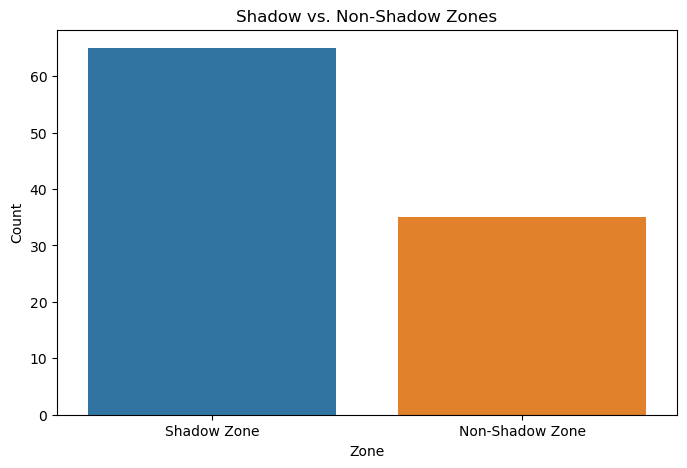

In [7]:

amplitude_50 = data['Max Amplitude'].median()  
frequency_25 = data['Dominant Frequency (Hz)'].quantile(0.25)  
phase_75 = data['Phase Shift (radians)'].quantile(0.75)  

amplitude_threshold = amplitude_50  
frequency_threshold = frequency_25  
phase_shift_threshold = phase_75  


def label_shadow_zone(row):
    if (row['Max Amplitude'] < amplitude_threshold) or \
       (row['Dominant Frequency (Hz)'] < frequency_threshold) or \
       (abs(row['Phase Shift (radians)']) > phase_shift_threshold):
        return "Shadow Zone"
    else:
        return "Non-Shadow Zone"


data['Zone'] = data.apply(label_shadow_zone, axis=1)


data.to_csv("labeled_seismic_data.csv", index=False)


print(data.head())


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Zone')
plt.title("Shadow vs. Non-Shadow Zones")
plt.xlabel("Zone")
plt.ylabel("Count")
plt.show()


Accuracy: 0.93

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        18
           1       1.00      0.83      0.91        12

    accuracy                           0.93        30
   macro avg       0.95      0.92      0.93        30
weighted avg       0.94      0.93      0.93        30



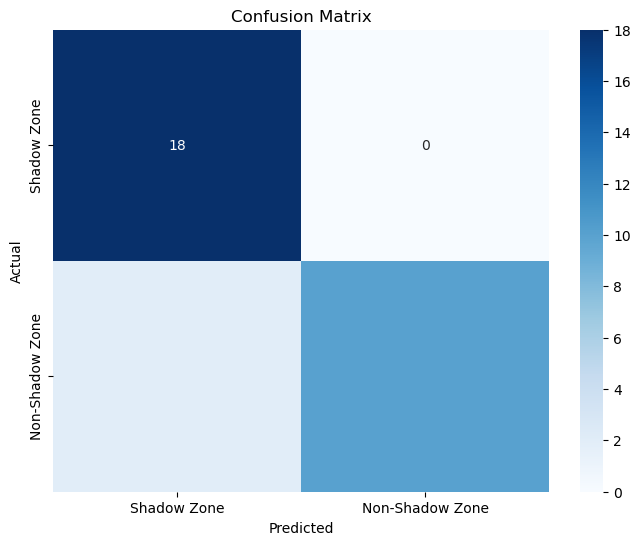

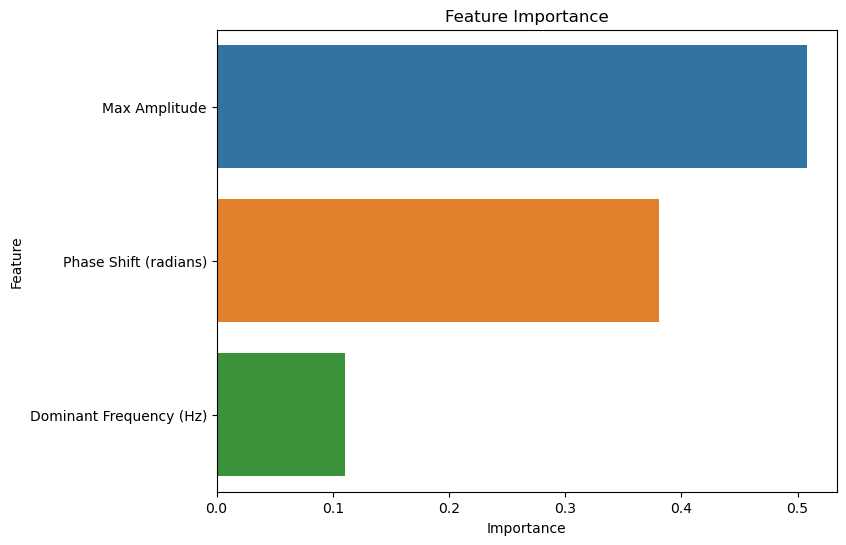

In [8]:

data['Zone'] = data['Zone'].map({"Shadow Zone": 0, "Non-Shadow Zone": 1})


X = data[["Max Amplitude", "Dominant Frequency (Hz)", "Phase Shift (radians)"]]
y = data["Zone"]


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_val)


accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")
print("Classification Report:")
print(classification_report(y_val, y_pred))


conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Shadow Zone", "Non-Shadow Zone"], yticklabels=["Shadow Zone", "Non-Shadow Zone"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)


plt.figure(figsize=(8, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Feature Importance")
plt.show()


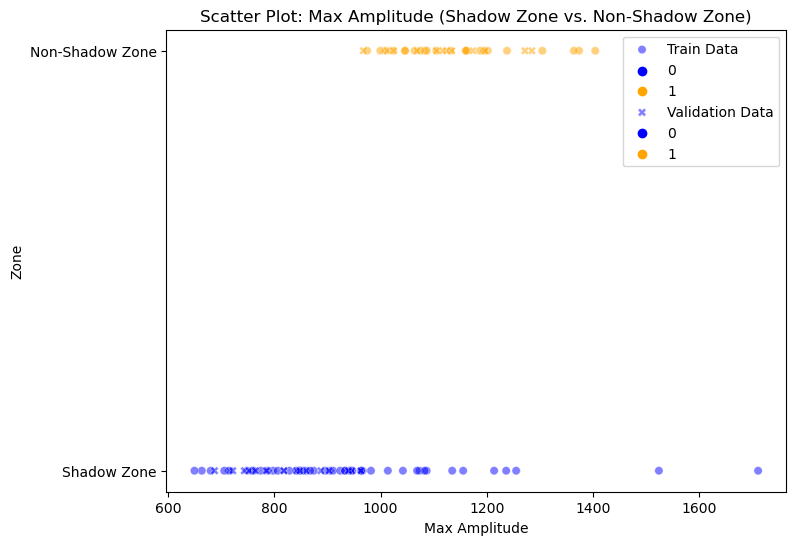

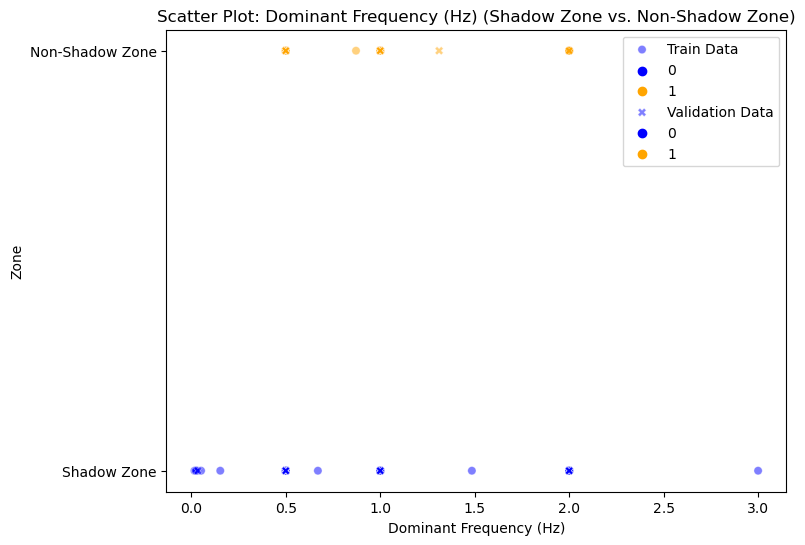

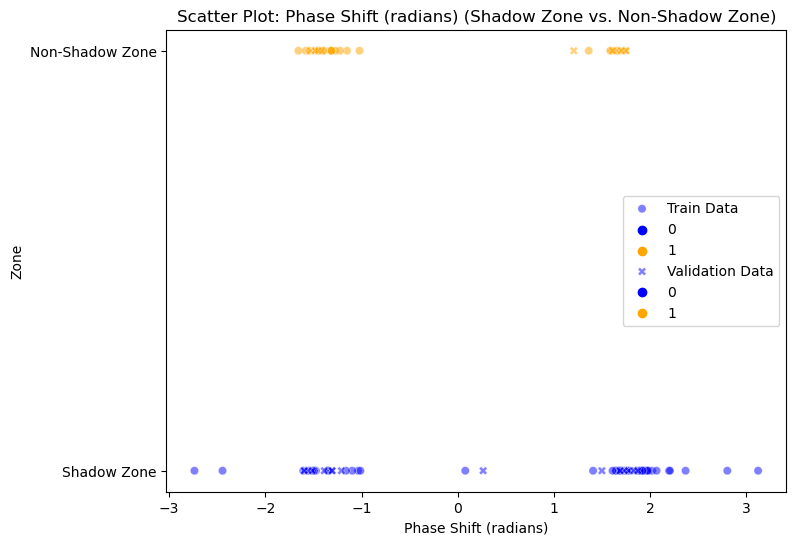

In [9]:
X_train['Zone'] = y_train
X_val['Zone'] = y_val


for feature in ["Max Amplitude", "Dominant Frequency (Hz)", "Phase Shift (radians)"]:
    plt.figure(figsize=(8, 6))
    
    
    sns.scatterplot(
        data=X_train, x=feature, y="Zone", label="Train Data", alpha=0.5, hue="Zone", palette={0: "blue", 1: "orange"}
    )
    
    
    sns.scatterplot(
        data=X_val, x=feature, y="Zone", label="Validation Data", alpha=0.5, hue="Zone", marker="X", palette={0: "blue", 1: "orange"}
    )
    
    plt.title(f"Scatter Plot: {feature} (Shadow Zone vs. Non-Shadow Zone)")
    plt.xlabel(feature)
    plt.ylabel("Zone")
    plt.yticks([0, 1], ["Shadow Zone", "Non-Shadow Zone"])
    plt.legend()
    plt.show()